In [12]:
engine_path=r"stockfish\stockfish-windows-x86-64-avx2.exe"
import pandas as pd
import chess
import chess.pgn
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [13]:
df=pd.read_csv("player_behavior_data.csv")
df.head()

Player_ID  Games_Played  Win_Rate  Average_Response_Time  \
0          1            61  0.637973               2.672103   
1          2            24  0.531250               2.664806   
2          3            81  0.309580               2.478244   
3          4            70  0.438536               1.686804   
4          5            30  0.444615               2.403109   

   Decision_Pattern_Score  Improvement_Rate  Mistakes_Per_Game  \
0                0.500975          0.022855           1.305648   
1                0.531259          0.017495           2.247177   
2                0.734861          0.098217           2.502015   
3                0.642302          0.051664           3.189939   
4                0.438935          0.026083           0.652613   

   Move_Matching_Accuracy  Complexity_Handled  Blunder_Rate  \
0                0.836013            0.537663      0.095230   
1                0.664076            0.624565      0.194164   
2                0.577521            0.891804      0.118635   
3                0.990920            0.570132      0.096225   
4                0.919467            0.506864      0.122334   

   Endgame_Efficiency  
0            0.713046  
1            0.611288  
2            0.698326  
3            0.945948  
4            0.573302

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = df[["Games_Played", "Win_Rate", "Average_Response_Time", 
                  "Decision_Pattern_Score", "Improvement_Rate", 
                  "Mistakes_Per_Game", "Move_Matching_Accuracy", 
                  "Complexity_Handled", "Blunder_Rate", "Endgame_Efficiency"]]

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_features)

# Display clustering results
df[["Player_ID", "Cluster"]].head()  # Show clustering results for all players


Player_ID  Cluster
0          1        0
1          2        0
2          3        2
3          4        1
4          5        0

In [24]:
cluster_dict = df.groupby('Cluster')['Player_ID'].apply(list).to_dict()

print(cluster_dict)

{0: [1, 2, 5, 11, 14, 19, 22, 33, 34, 39, 40, 43, 46, 48], 1: [4, 10, 12, 15, 27, 36, 37, 41, 50], 2: [3, 6, 7, 9, 16, 23, 24, 29, 32, 35, 49], 3: [8, 13, 17, 18, 20, 21, 25, 26, 28, 30, 31, 38, 42, 44, 45, 47]}


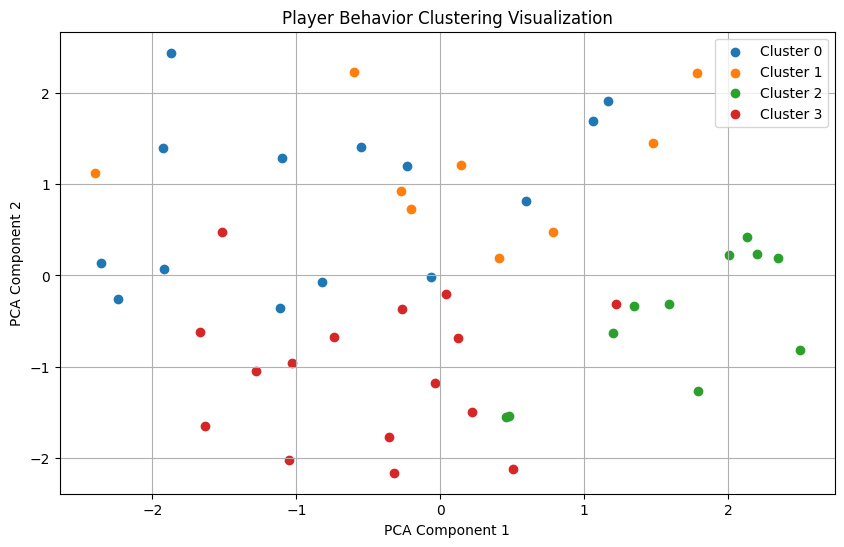

{3: 16, 0: 14, 2: 11, 1: 9}

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(n_clusters):
    plt.scatter(reduced_features[df["Cluster"] == cluster_id, 0], 
                reduced_features[df["Cluster"] == cluster_id, 1], 
                label=f"Cluster {cluster_id}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Player Behavior Clustering Visualization")
plt.legend()
plt.grid()
plt.show()

# Count number of players in each cluster
cluster_counts = df["Cluster"].value_counts().to_dict()
cluster_counts


In [ ]:
# # Define weights for performance score calculation
# weights = {
#     "Win_Rate": 0.4,             # High weight for win rate
#     "Mistakes_Per_Game": -0.3,   # Negative weight for mistakes
#     "Complexity_Handled": 0.2,   # Moderate weight for complexity handled
#     "Endgame_Efficiency": 0.1    # Low weight for endgame efficiency
# }

# # Apply performance score formula to the dfframe
# df["Performance_Score"] = (
#     weights["Win_Rate"] * df["Win_Rate"] +
#     weights["Mistakes_Per_Game"] * df["Mistakes_Per_Game"] +
#     weights["Complexity_Handled"] * df["Complexity_Handled"] +
#     weights["Endgame_Efficiency"] * df["Endgame_Efficiency"]
# )

# # Group by cluster and calculate the mean performance score for each cluster
# cluster_weights = df.groupby("Cluster")["Performance_Score"].mean().sort_values(ascending=False)

# player_cluster_map = {idx: clusters[idx] for idx in range(len(player_moves))}
# # Display results
# print(cluster_weights)


Cluster
3   -0.009137
0   -0.107830
1   -0.226278
2   -0.382642
Name: Performance_Score, dtype: float64


In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


# Simulated longer chess games data
data = [
    {"player_id": "1", "moves":'e2e4 d2d4 g1f3 f2f4 e7e5 d7d5 g8f6 e1g1'},
    {"player_id": "2", "moves":'e2e4 g1f3 f2f4 d2d4 e7e5 d7d5 g8f6 e1g1 a2a4'},
    {"player_id": "3", "moves":'e2e4 d2d4 e7e5 f2f4 g8f6 a2a3 d7d5 e1g1'},
    {"player_id": "4", "moves":'e4 d4 e3 d3 g1f3 f2f4 e7e5 d7d5 g8f6 e1g1'},
    {"player_id": "5", "moves":'f2f4 g2g3 e2e4 d4d3 e7e5 d7d5 f2f4 g1f3 a2a4'}
]

# Tokenization
def create_model(data,nbr):
    tokenizer = Tokenizer(filters='')  # Avoid filtering special characters
    tokenizer.fit_on_texts(data)  # Fit tokenizer on all moves
    sequences = tokenizer.texts_to_sequences(data)  # [4, 8, 5, 1, 2, 3, 6, 7], [4, 5, 1, 8, 2, 3, 6, 7, 9],
    word_index = tokenizer.word_index  # {'f2f4': 1, 'e7e5': 2, 'd7d5': 3, 'e2e4': 4, 'g1f3': 5, 'g8f6': 6, 'e1g1': 7, 'd2d4': 8, 'a2a4': 9, 'a2a3': 10, 'e4': 11, 'd4': 12, 'e3': 13, 'd3': 14, 'g2g3': 15, 'd4d3': 16}
    vocab_size = len(word_index) + 1  #len(word_index)+padding

    # Prepare input-output pairs with multi-step target
    sequence_length = 5  # Increased number of past moves to consider as input
    X = []
    y = []

    # Iterate through sequences to create data for multi-step prediction
    for seq in sequences:
        for i in range(len(seq) - sequence_length - 2):  # Ensure at least 3 steps forward
            # Input is the last 5 moves
            X.append(seq[i:i + sequence_length])
            # Output is the next 3 moves
            y.append(seq[i + 1:i + 4])  # Extract the next 3 moves

    X = np.array(X)  # Convert X into NumPy array
    y = np.array(y)  # Convert y into NumPy array

    # One-hot encode each move for all three target steps
    y = np.array([to_categorical(move_sequence, num_classes=vocab_size) for move_sequence in y])

    # Build the LSTM model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length),
        LSTM(128, return_sequences=False),
        Dense(vocab_size * 3, activation='softmax')  # Predict three moves at once
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X, y.reshape(y.shape[0], -1), epochs=50, batch_size=32, validation_split=0.2)

    return model,tokenizer

    # Save the model
    # model.save("cluster",nbr,"".h5")

    # with open("tokenizer",nbr,".pkl", "wb") as file:
    #     pickle.dump(tokenizer, file)

    # print("Model trained and saved.")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0000e+00 - loss: 11.7920 - val_accuracy: 0.0000e+00 - val_loss: 11.7965
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.0000e+00 - loss: 11.7708 - val_accuracy: 0.0000e+00 - val_loss: 11.7995
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0000e+00 - loss: 11.7490 - val_accuracy: 0.0000e+00 - val_loss: 11.8028
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.0000e+00 - loss: 11.7259 - val_accuracy: 0.0000e+00 - val_loss: 11.8065
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0000e+00 - loss: 11.7009 - val_accuracy: 0.0000e+00 - val_loss: 11.8108
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.0000e+00 - loss: 11.6730 - val_accuracy: 0.0000e+00 - val_loss: 11.8158
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.0000e+00 - loss: 11.6416 - val_accuracy: 0.0000e+00 - val_loss: 11.8218
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step -

Model trained and saved.


In [ ]:
sequence_length=5
def predict_next_moves(input_sequence,tokenizer,model):
    word_index = tokenizer.word_index  # {'f2f4': 1, 'e7e5': 2, 'd7d5': 3, 'e2e4': 4, 'g1f3': 5, 'g8f6': 6, 'e1g1': 7, 'd2d4': 8, 'a2a4': 9, 'a2a3': 10, 'e4': 11, 'd4': 12, 'e3': 13, 'd3': 14, 'g2g3': 15, 'd4d3': 16}
    vocab_size = len(word_index) + 1
    """Predict the next three moves given the input sequence."""
    # Tokenize input
    tokenized_input = tokenizer.texts_to_sequences([input_sequence])[0]
    padded_input = np.pad(tokenized_input, (sequence_length - len(tokenized_input), 0), 'constant')
    input_array = np.array(padded_input).reshape(1, sequence_length)

    # Predict probabilities
    predictions = model.predict(input_array)[0]
    
    next_moves = [
        np.argmax(predictions[:vocab_size]),
        np.argmax(predictions[vocab_size:vocab_size*2]),
        np.argmax(predictions[vocab_size*2:])
    ]
    
    # Map predictions back to moves
    predicted_moves = [tokenizer.index_word[idx] for idx in next_moves]
    return predicted_moves


# Example
input_sequence = 'e2e4 d2d4 g1f3'
predicted_moves = predict_next_moves(input_sequence)

print(f"Predicted next 3 moves: {predicted_moves}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted next 3 moves: ['d2d4', 'g1f3', 'f2f4']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Prepare training data by cluster
cluster_models = {}
for cluster_id in range(n_clusters):#global
    # Get the data for this specific cluster
    players_in_cluster=cluster_dict [cluster_id]
    filtered_moves = df[
    df['White'].isin(players_in_cluster) | df['Black'].isin(players_in_cluster)  ]

    moves_df = filtered_moves[['Moves']].reset_index(drop=True)

    model=create_model(moves_df)#,cluster_id

    # Store trained model for this cluster
    cluster_models[cluster_id] = model
